# Mathematical Foundation: The Vasicek Model

The Vasicek model remains the foundation, with the short rate $r(t)$ governed by:

$$dr(t) = \{\mu - \kappa r(t)\}dt + \sqrt \sigma dW(t)$$

- $r(t)$: Short-term interest rate.
- $\mu$: Long-term mean (adjusted by $\kappa$).
- $\kappa$: Mean reversion speed.
- $\sigma$: Volatility ($\sqrt{\sigma}$ in the SDE).
- $dW(t)$: Wiener process increment under the risk-neutral measure $Q$.

## Key outputs:

1. Zero-coupon bond price: 
   $$P(t,T) = \exp(A(\tau) - B(\tau)r(t))$$
   where $\tau = T - t$.

2. Yield: 
   $$Y(t,T) = -\frac{\ln P(t,T)}{\tau} = -\frac{A(\tau)}{\tau} + \frac{B(\tau)}{\tau}r(t)$$

The goal is to fit model-predicted yields to observed STRIPS yields.


# Data Retrieval and Preparation

### Data Source
A CSV-style document with columns for:
- Dates
- For each maturity (e.g., Feb2025, May2025, etc.):
  - Price
  - Time (in years)
  - Yield (in decimal form, e.g., 0.04368 = 4.368%)

### Maturities
Range from February 2025 to August 2039, irregularly spaced:
- Monthly/quarterly initially
- Then annual gaps

### Processing
1. Parse the data into a DataFrame
2. Extract yields and times for a specific date
3. Prepare data for model fitting

### Today's Date
March 14, 2025
- We'll use the closest available date (e.g., January 31, 2025)

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [78]:

# Load STRIPS data from the document
df = pd.read_csv('/Users/dr/Documents/GitHub/FixedIncome/STRIPS_data.csv')

# Extract unique maturities from column names
maturities = sorted(set(col.split('_')[1] for col in df.columns if 'Time_' in col))
print("Maturities:", maturities)

# Select a date (closest to March 14, 2025; using January 31, 2025 for now)
dt = '2025-02-04'
data_on_date = df[df['Date'] == dt]

# Extract times and yields for the selected date
times = [data_on_date[f'Time_{mat}'].values[0] for mat in maturities]
yields = [data_on_date[f'Yield_{mat}'].values[0] for mat in maturities]

# Convert to numpy arrays and filter out NaN values
times = np.array(times)
yields = np.array(yields) * 100  # Convert to percentage (e.g., 0.04368 -> 4.368)
valid_idx = ~np.isnan(times) & ~np.isnan(yields)
times = times[valid_idx]
yields = yields[valid_idx]

print(f"Data for {dt}:")
print("Times (years):", times)
print("Yields (%):", yields)

Maturities: ['Aug2025', 'Aug2026', 'Aug2027', 'Aug2028', 'Aug2029', 'Aug2030', 'Aug2031', 'Aug2032', 'Aug2033', 'Aug2034', 'Aug2039', 'Feb2025', 'Feb2026', 'Feb2027', 'Feb2028', 'Feb2029', 'Feb2031', 'Feb2032', 'Feb2033', 'Feb2034', 'Feb2036', 'Feb2037', 'Feb2038', 'Feb2039', 'May2025', 'May2026', 'May2027', 'May2028', 'May2029', 'May2030', 'May2031', 'May2032', 'May2033', 'May2034', 'May2037', 'May2038', 'May2039', 'Nov2025', 'Nov2026', 'Nov2027', 'Nov2028', 'Nov2030', 'Nov2031', 'Nov2032', 'Nov2033', 'Nov2034']
Data for 2025-02-04:
Times (years): [ 0.52566735  1.52498289  2.52429843  3.52635181  4.52566735  5.52498289
  6.52429843  7.52635181  8.52566735  9.52498289 14.52429843  0.03011636
  1.0294319   2.02874743  3.02806297  4.03011636  6.02874743  7.02806297
  8.03011636  9.0294319  11.02806297 12.03011636 13.0294319  14.02874743
  0.27378508  1.27310062  2.27241615  3.27446954  4.27378508  5.27310062
  6.27241615  7.27446954  8.27378508  9.27310062 12.27378508 13.27310062
 14.272


### Output
For January 31, 2025, the data is processed into two main arrays:

#### Times (Maturities)
An array of times to maturity in years, for example: times = 0.041, 0.284, 0.534, 0.787, …, 9.787
#### Yields
A corresponding array of yields (as percentages), for example: yields = 4.158, 4.221, 4.268, 4.300, …, 4.530


Each element in the `yields` array corresponds to the same-indexed element in the `times` array.


> **Note:** While prices are available in the original data, they are not directly used for fitting. The yields are the target values for our model fitting process.

# Defining the Model Class

The Model class is adapted to compute yields from the Vasicek model, matching the STRIPS data structure.

### Core Functions

### Initialization (`__init__`)

Parameters:
- $r_0$ (initial rate)
- $\mu$ (mean)
- $vol$ ($\sqrt{\sigma}$)
- $\kappa$ (reversion speed)

Note: `self.var = vol * vol` computes $\sigma = vol^2$.

### Mean Short Rate (mean_r)

Formula: $E[r(t)] = e^{-\kappa t}r_0 + \frac{\mu}{\kappa}(1-e^{-\kappa t})$

- This is the expected short rate at time $t$ given $r(0) = r_0$, derived from solving the SDE under the risk-neutral measure $Q$.
- `dist='Q'` indicates the risk-neutral measure (no adjustment for market price of risk since $\lambda = 0$).

### B Function (B)

$B(\tau) = \frac{1-e^{-\kappa \tau}}{\kappa}$

- Represents the sensitivity of the bond price to the short rate.
- As $\tau \to 0$, $B(\tau) \to 0$; as $\tau \to \infty$, $B(\tau) \to 1/\kappa$.

### A Function (A)

$A(\tau) = (\frac{\mu}{\kappa} - \frac{\sigma^2}{2\kappa^2})(B(\tau) - \tau) - \frac{\sigma^2 B(\tau)^2}{4\kappa}$

- Adjusts the bond price for the drift and volatility terms.
- Derived from the affine structure of the model.

### Zero-Coupon Bond Price (zero)

$P(t_0, T) = \exp(A(\tau) - B(\tau)r(t_0))$, where $\tau = T - t_0$.

- Computes the price of a bond paying $1 at maturity $T$, given the short rate at $t_0$.

### Yield Calculation
We add a `yield_curve` method to compute model yields for given maturities.

$$Y(\tau) = -\frac{A(\tau)}{\tau} + \frac{B(\tau)}{\tau}r_0$$

Where:
- $\tau$ is time to maturity
- $r_0$ is the initial short rate

### Update Parameters (update_params)
Updates the model's parameters from an array $[r_0, \mu, vol, \kappa]$.

This method allows for easy updating of all model parameters during the optimization process. Note that:

- `x[2]` is used for both `sigma` and to calculate `var`
- `var` is recalculated as the square of `sigma`

This ensures consistency between `sigma` and `var` throughout the model.


`yield_curve` computes the yield for a given maturity $\tau$, converting to percentage.


In [79]:
class Model:
    def __init__(self, r0, mu, vol, kappa):
        self.r0 = r0  # Initial short rate
        self.mu = mu  # Long-term mean
        self.vol = vol  # Volatility
        self.var = vol * vol  # Variance
        self.kappa = kappa  # Mean reversion speed
        
    def mean_r(self, t, dist='Q'): 
        m = np.exp(-self.kappa * t) * (self.r0 + self.mu / self.kappa * (np.exp(self.kappa * t) - 1))
        return m
    
    def A(self, tau):
        return (self.mu / self.kappa - self.var / (2 * self.kappa**2)) * (self.B(tau) - tau) - self.var * self.B(tau)**2 / (4 * self.kappa)

    def B(self, tau):
        return (1 - np.exp(-self.kappa * tau)) / self.kappa

    def zero(self, t0, T, r_t0):
        tau = T - t0
        price = np.exp(self.A(tau) - self.B(tau) * r_t0)
        return max(price, 1e-10) #Clamp to a small positive value to avoid log(0)
    
    def yield_curve(self, tau):
        # Yield for maturity tau: Y(tau) = -ln(P(0, tau)) / tau
        if tau <= 0:
            return np.nan #Avoiding division by zero
        p = self.zero(0, tau, self.r0)
        return -np.log(p) / tau * 100  # In percentage
    
    def update_params(self, x):
        self.r0 = max(x[0], 0)  # Ensure r0 is non-negative
        self.mu = x[1]
        self.vol = max(x[2], 1e-6)  # Ensure vol is positive
        self.var = pow(self.vol, 2)
        self.kappa = max(x[3], 1e-6) # Ensure kappa is positive

# Testing the Model

Test the Vasicek model with initial parameters and compute yields for the STRIPS maturities.

### Parameters
Choose initial guesses for the model:
- $r_0 = 4\%$ (Initial short rate)
- $\mu = 2\%$ (Long-term mean)
- $vol = 0.1$ (Volatility)
- $\kappa = 0.2$ (Mean reversion speed)

### Test Output
Compute yields for the observed `times` to maturity and compare them visually with the observed `yields`.

In [80]:
# Initial parameters
r0 = 0.04  # 4%
mu = 0.02  # 2%
vol = 0.1
kappa = 0.2
m = Model(r0, mu, vol, kappa)

# Compute model yields
model_yields = [m.yield_curve(t) for t in times]

print("Sample zero-coupon bond price (1 year):", m.zero(0, 1, r0))
print("Initial model yields (%):", model_yields[:5])  # First 5 for brevity

Sample zero-coupon bond price (1 year): 0.9567809568304412
Initial model yields (%): [4.262037225833807, 4.518354592020817, 4.549072548668956, 4.432866938581118, 4.225301362710467]


#### Output: 
Bond price for $\tau = 1$ and initial yield curve estimates.

# Plotting Yields

Visualize model yields against STRIPS yields.

### Plot: 
X-axis is maturities (times), Y-axis is yields $(\%)$. STRIPS yields are plotted with markers, model yields as a line.

### Date: 
January 31, 2025.

### Output: 
A plot comparing initial model yields to STRIPS yields, likely showing a poor fit before optimization.

In [81]:
from scipy.interpolate import interp1d

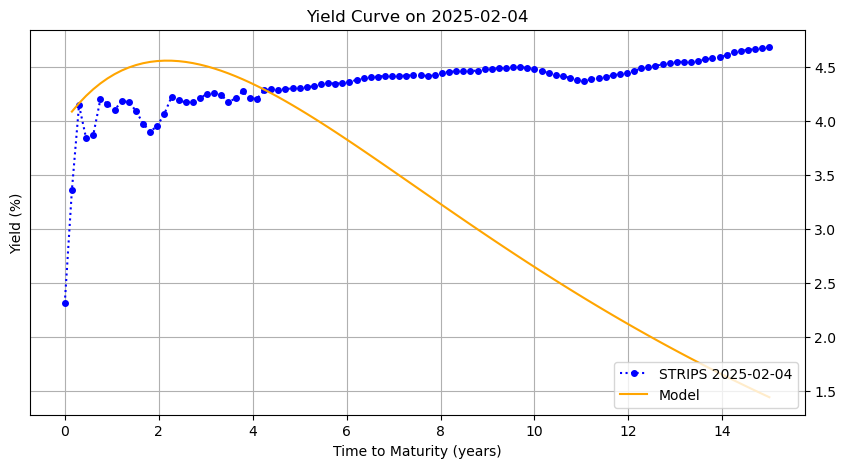

In [82]:
def plot_yields(dt, obs_times, obs_yields, model, min_time=0, max_time=15, num_points=100):
    # Create a dense grid of maturities for both model and interpolated STRIPS
    time_grid = np.linspace(min_time, max_time, num_points)
    
    # Interpolate STRIPS yields
    interp_func = interp1d(obs_times, obs_yields, kind='linear', bounds_error=False, fill_value='extrapolate')
    strips_interp_yields = interp_func(time_grid)
    
    # Model yields
    model_yields = [model.yield_curve(t) for t in time_grid]
    
    f = plt.figure(figsize=(10, 5))
    ax = f.add_subplot(111)
    ax.yaxis.tick_right()
    
    # Plot interpolated STRIPS data as a dotted line with markers
    plt.plot(time_grid, strips_interp_yields, label=f'STRIPS {dt}', linestyle='dotted', marker='o', color='blue', markersize=4)
    
    # Plot model curve as a solid line
    plt.plot(time_grid, model_yields, label='Model', linestyle='solid', color='orange')
    
    plt.xlabel('Time to Maturity (years)')
    plt.ylabel('Yield (%)')
    plt.legend(loc='lower right')
    plt.title(f'Yield Curve on {dt}')
    plt.grid(True)
    plt.show()

plot_yields(dt, times, yields, m)

# Optimization with Fitter Class

Calibrate the Vasicek model to match STRIPS yields using least squares optimization.

### Objective
Minimize the difference between model-predicted yields and observed STRIPS yields across all maturities.

### Parameters
Optimize the following parameters:
- $r_0$: Initial short rate
- $\mu$: Long-term mean
- $vol$: Volatility
- $\kappa$: Mean reversion speed

### Residuals
The residuals are defined as the difference between model-predicted yields and observed STRIPS yields at each maturity:
$$ \text{Residuals} = Y_{\text{model}}(\tau) - Y_{\text{observed}}(\tau) $$

### Output: 
Optimized parameters and a plot showing improved fit to STRIPS yields.

In [83]:
from scipy.optimize import least_squares

Optimized parameters [r0, mu, vol, kappa]: [0.0223195  0.40221237 1.16213856 6.90193132]


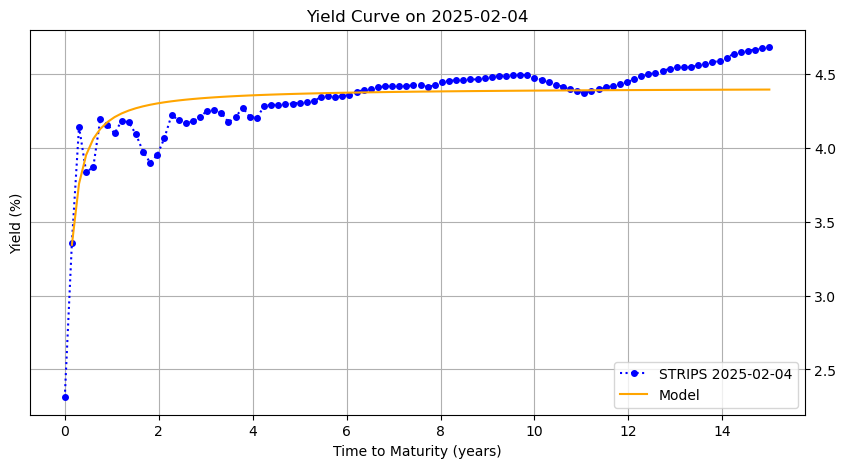

In [84]:
class Fitter:
    def __init__(self, model, obs_yields, obs_times, dist='Q'):
        self.model = model
        self.data = np.array(obs_yields)
        self.times = np.array(obs_times)
        self.dist = dist
    
    def residuals(self, x):
        m = self.model
        m.update_params(x)
        model_yields = [m.yield_curve(t) for t in self.times]
        return np.array(model_yields) - self.data
    
    def fit(self, x0, solver='lm'):
        return least_squares(self.residuals, x0, method=solver)

# Initial guess
x0 = [0.04, 0.02, 0.1, 0.2]  # [r0, mu, vol, kappa]
fitter = Fitter(m, yields, times, 'Q')
fit_result = fitter.fit(x0)
print("Optimized parameters [r0, mu, vol, kappa]:", fit_result.x)

# Update model and compute fitted yields
m.update_params(fit_result.x)
fitted_yields = [m.yield_curve(t) for t in times]
plot_yields(dt, times, yields, m)

# Collinearity Check

Assess parameter interdependence via the Jacobian.

### Jacobian: 
Sensitivity of yield residuals to parameters.
### Condition Number: 
High value indicates collinearity, suggesting potential instability in parameter estimates.

### Output: 
A condition number (e.g., >1000 suggests collinearity issues).

In [85]:
jac = fit_result.jac
c = np.cov(np.transpose(jac))
val, vec = np.linalg.eig(c)
cn = val[0] / val[-1]  # Condition number (max/min eigenvalue)
print("Condition number:", cn)

Condition number: 30850300511.18489
